In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loading train_transaction data
train_transaction = pd.read_csv('train_transaction.csv')
print(train_transaction.shape)
train_transaction = reduce_mem_usage(train_transaction)
train_transaction.head()

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Loading train_identity data
train_identity = pd.read_csv('train_identity.csv')
print(train_identity.shape)
train_identity = reduce_mem_usage(train_identity)
train_identity.head()

(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_df = pd.merge(train_transaction, train_identity, how='left')
print(train_df.shape)
len_train_df = len(train_df)
del train_transaction, train_identity
train_df.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
# Loading test data
test_transaction = pd.read_csv('test_transaction.csv')
print(test_transaction.shape)
test_transaction = reduce_mem_usage(test_transaction)

test_identity = pd.read_csv('train_identity.csv')
print(test_identity.shape)
test_identity = reduce_mem_usage(test_identity)

test_df = pd.merge(test_transaction, test_identity, how='left')
test_df.columns = train_df.drop('isFraud', axis=1).columns
print(test_df.shape)
del test_transaction, test_identity
test_df.head()

(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%
(506691, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
submission = pd.DataFrame({'TransactionID':test_df.TransactionID})
y = train_df['isFraud']
train_df.drop(columns=['isFraud', 'TransactionID'], inplace = True)
test_df.drop(columns=['TransactionID'] , inplace = True)

train_df, valid_df, y_train, y_valid = train_test_split(train_df, y, train_size=0.8, test_size=0.2, random_state=0)

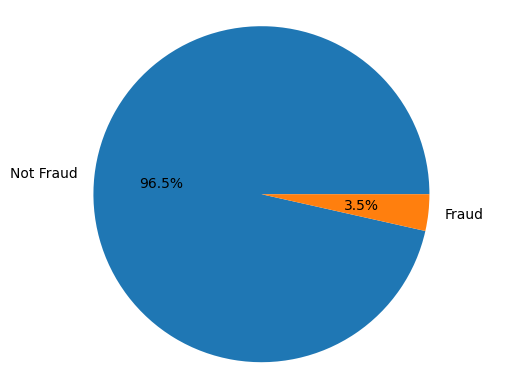

In [8]:
# Class imbalance check
plt.pie(pd.DataFrame(y_train).isFraud.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [9]:
# Missing values check

# Dropping columns with more than 20% missing values 
mv = train_df.isnull().sum()/len(train_df)
train_mv_df = train_df.drop(columns=mv[mv>0.2].index)
valid_mv_df = valid_df.drop(columns=mv[mv>0.2].index)
test_mv_df = test_df.drop(columns=mv[mv>0.2].index)

#del train_df, test_df, valid_df
print(train_mv_df.shape)
print(test_mv_df.shape)

(472432, 180)
(506691, 180)


In [10]:
# Filtering numerical data
train_num_mv_df = train_mv_df.select_dtypes(include=np.number)
print(train_num_mv_df.shape)
valid_num_mv_df = valid_mv_df.select_dtypes(include=np.number)
print(valid_num_mv_df.shape)
test_num_mv_df = test_mv_df.select_dtypes(include=np.number)
print(test_num_mv_df.shape)

# Filtering categorical data
train_cat_mv_df = train_mv_df.select_dtypes(exclude=np.number)
print(train_cat_mv_df.shape)
valid_cat_mv_df = valid_mv_df.select_dtypes(exclude=np.number)
print(valid_cat_mv_df.shape)
test_cat_mv_df = test_mv_df.select_dtypes(exclude=np.number)
print(test_cat_mv_df.shape)
#del train_mv_df, test_mv_df

# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
train_num_df = pd.DataFrame(imp_median.fit_transform(train_num_mv_df), columns=train_num_mv_df.columns)
valid_num_df = pd.DataFrame(imp_median.transform(valid_num_mv_df), columns=valid_num_mv_df.columns)
test_num_df = pd.DataFrame(imp_median.transform(test_num_mv_df), columns=test_num_mv_df.columns)
#del train_num_mv_df, test_num_mv_df
print(train_num_df.shape)
print(test_num_df.shape)


# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_cat_df = pd.DataFrame(imp_max.fit_transform(train_cat_mv_df), columns=train_cat_mv_df.columns)
valid_cat_df = pd.DataFrame(imp_max.transform(valid_cat_mv_df), columns=valid_cat_mv_df.columns)
test_cat_df = pd.DataFrame(imp_max.transform(test_cat_mv_df), columns=test_cat_mv_df.columns)
#del train_cat_mv_df, test_cat_mv_df
print(train_cat_df.shape)
print(test_cat_df.shape)

# Concatinating numerical and categorical data
train_df_cleaned = pd.concat([train_num_df, train_cat_df], axis=1)
valid_df_cleaned = pd.concat([valid_num_df, valid_cat_df], axis=1)
test_df_cleaned = pd.concat([test_num_df, test_cat_df], axis=1)
#del train_num_df, train_cat_df, test_num_df, test_cat_df,

# Verifying missing values - train set
print(f'Total missing values: {train_df_cleaned.isnull().sum().sum()}')
print(train_df_cleaned.shape)
train_df_cleaned.head()

(472432, 176)
(118108, 176)
(506691, 176)
(472432, 4)
(118108, 4)
(506691, 4)
(472432, 176)
(506691, 176)
(472432, 4)
(506691, 4)
Total missing values: 0
(472432, 180)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V316,V317,V318,V319,V320,V321,ProductCD,card4,card6,P_emaildomain
0,5069957.0,441.0000,13809.0,583.0,150.0,226.0,204.0,87.0,2.0,2.0,...,0.0,0.0,0.0,440.950012,440.950012,440.950012,W,visa,credit,yahoo.com
1,14773564.0,460.0000,12695.0,490.0,150.0,226.0,325.0,87.0,2.0,2.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,W,visa,debit,hotmail.com
2,9207277.0,49.0000,12695.0,490.0,150.0,226.0,325.0,87.0,2.0,3.0,...,117.0,485.0,194.0,0.000000,0.000000,0.000000,W,visa,debit,frontier.com
3,3874678.0,35.9375,18132.0,567.0,150.0,117.0,204.0,87.0,137.0,122.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,W,mastercard,debit,gmail.com
4,6225517.0,113.0000,17399.0,111.0,150.0,224.0,204.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,W,mastercard,debit,gmail.com


In [11]:
# Verifying missing values - valid set
print(f'Total missing values: {valid_df_cleaned.isnull().sum().sum()}')
print(valid_df_cleaned.shape)
valid_df_cleaned.head()

Total missing values: 0
(118108, 180)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V316,V317,V318,V319,V320,V321,ProductCD,card4,card6,P_emaildomain
0,242834.0,25.000000,9803.0,583.0,150.0,226.0,269.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,visa,credit,yahoo.com
1,15123000.0,117.000000,7919.0,194.0,150.0,166.0,181.0,87.0,1.0,4.0,...,288.0,1707.0,1707.0,0.0,0.0,0.0,W,mastercard,debit,gmail.com
2,8378575.0,73.750000,12778.0,500.0,185.0,224.0,284.0,60.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,C,mastercard,credit,hotmail.com
3,2607840.0,400.000000,12316.0,548.0,150.0,195.0,441.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,R,visa,credit,anonymous.com
4,12226544.0,31.953125,9002.0,453.0,150.0,226.0,264.0,87.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,visa,debit,yahoo.com


In [12]:
# Verifying missing values - test set
print(f'Total missing values: {test_df_cleaned.isnull().sum().sum()}')
print(test_df_cleaned.shape)
test_df_cleaned.head()

Total missing values: 0
(506691, 180)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V316,V317,V318,V319,V320,V321,ProductCD,card4,card6,P_emaildomain
0,18403224.0,31.953125,10409.0,111.0,150.0,226.0,170.0,87.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,visa,debit,gmail.com
1,18403263.0,49.000000,4272.0,111.0,150.0,226.0,299.0,87.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,visa,debit,aol.com
2,18403310.0,171.000000,4476.0,574.0,150.0,226.0,472.0,87.0,2.0,2.0,...,0.0,0.0,0.0,0.0,263.0,0.0,W,visa,debit,hotmail.com
3,18403310.0,285.000000,10989.0,360.0,150.0,166.0,205.0,87.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,visa,debit,gmail.com
4,18403317.0,67.937500,18018.0,452.0,150.0,117.0,264.0,87.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,mastercard,debit,gmail.com


In [13]:
train_df_cleaned.select_dtypes(exclude=np.number).nunique(axis=0)

ProductCD         5
card4             4
card6             4
P_emaildomain    59
dtype: int64

In [14]:
cat_cols = train_df_cleaned.select_dtypes(exclude=np.number).columns

In [15]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_df_cleaned[cat_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(valid_df_cleaned[cat_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_df_cleaned[cat_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = train_df_cleaned.index
OH_cols_valid.index = valid_df_cleaned.index
OH_cols_test.index = test_df_cleaned.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_df_cleaned.drop(cat_cols, axis=1)
num_X_valid = valid_df_cleaned.drop(cat_cols, axis=1)
num_X_test = test_df_cleaned.drop(cat_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

print(OH_X_train.shape)

(472432, 248)


In [16]:
# Random Forest Classifier
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
rfc.fit(OH_X_train, y_train)
y_predproba = rfc.predict_proba(OH_X_valid)
print(f'Validation AUC={roc_auc_score(y_valid, y_predproba[:, 1])}')

Validation AUC=0.9199819734903087


In [19]:
pd.value_counts(y_train)

0    455821
1     16611
Name: isFraud, dtype: int64

In [20]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(OH_X_train, y_train)
pd.value_counts(y_train_smote)

0    455821
1    455821
Name: isFraud, dtype: int64

In [21]:
# Random Forest Classifier
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
rfc.fit(X_train_smote, y_train_smote)
y_predproba = rfc.predict_proba(OH_X_valid)
print(f'Validation AUC={roc_auc_score(y_valid, y_predproba[:, 1])}')

Validation AUC=0.904360941856656


In [22]:
predictions = rfc.predict_proba(OH_X_test)
submission['isFraud'] = predictions[:, 1]
print(submission.shape)
submission.head()

(506691, 2)


,TransactionID,isFraud
0,3663549,0.021529
1,3663550,0.013809
2,3663551,0.041209
3,3663552,0.030322
4,3663553,0.040259


In [23]:
submission.to_csv('submission.csv', index=False)